In [1]:
! pip install pandas-profiling
! pip install ydata-profiling

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

# Step 0: Read the train dataset and get a general idea on how it looks like

In [3]:
df = pd.read_csv('Data/train.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Step 1: Understand the general profile of this dataset and how consistently populated are its features

In [4]:
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile.to_file('RawDataProfile.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# Overall, columns are consistently populated. There are no duplicates.
# Earth is the most frequent home planet, followed by Europa and Mars
# Most people didn't undergo Cryo Sleep
# There is a large number of distinct cabins, and some cabins have more than one person
# The most common destination is TRAPPIST-1e, followed by 55 Cancri e and PSO J318.5-22
# The age distibution is quite sparse, with a std dev of 14 year and most people in their 20s - some extreme values (babies and people at an old age)
# A very small portion of the population was VIP
# Most people did not spend any money on room RoomService/FoodCourt/ShoppingMall/Spa/VRDeck
# The number of people that were transported is close to the number of people who were not transported, so it is a balanced data set

# Step 2: Feature Engineering - Adding new features from the raw data

In [6]:
def last_name(name):
  name = str(name)
  return name.split(' ')[-1]

def first_name(name):
  name = str(name)
  return name.split(' ')[0]

## Adding a new feature: Family (derived from last name)

In [7]:
df['Family'] = df['Name'].apply(lambda name: last_name(name))

<Axes: ylabel='Frequency'>

2     400
3     388
1     382
4     320
5     256
6     173
7     119
8      68
9      35
10     30
11     25
12      7
13      6
14      4
15      2
18      1
16      1
0       1
Name: FamilySize, dtype: int64

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Family,FamilySize
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Ofracculy,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,Vines,4
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Susent,6
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Susent,6
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Santantines,6


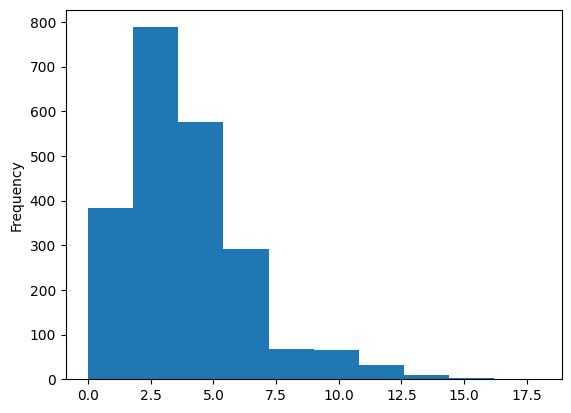

In [8]:
# Trying to get an idea of how many people there are in each family
df_fam_size = df[['Family', 'Name']].groupby('Family').agg({'Name': 'count'}).reset_index().rename({'Name': 'FamilySize'}, axis='columns').sort_values(by='FamilySize', ascending=False)

# Adding the Family Size to the original dataframe
df_family = df[['Family', 'Name']].groupby('Family').size().reset_index(name='FamilySize')
df = df.merge(df_fam_size, on='Family', how='left')

display(
    df_fam_size['FamilySize'].plot.hist(bins=10),
    df_fam_size['FamilySize'].value_counts(),
    df.head()
)

In [9]:
df['Family'] = df['Family'].str.replace('nan', 'Unknown')

## Adding a new feature: gender

In [10]:
! pip install gender-guesser

In [11]:
import gender_guesser.detector as gender

In [12]:
detector = gender.Detector()

In [13]:
df['FirstName'] = df['Name'].apply(lambda name: first_name(name))
df['FirstName'] = df['FirstName'].str.capitalize()
df['Sex'] = df['FirstName'].apply(lambda first_name: detector.get_gender(first_name))

In [14]:
df['Sex'].value_counts()

unknown          7084
female            811
male              423
mostly_female     223
mostly_male        81
andy               71
Name: Sex, dtype: int64

In [15]:
# Given the large number of unknowns here, I guess we won't have much luck if we use this attribute
# Therefore I will delete it

In [16]:
# Trying to get an idea of how many people survived in each family
df['Transported'] = df['Transported'].astype('int32')
df[['Family', 'FamilySize', 'Transported']].groupby(['Family', 'FamilySize']).sum().reset_index().sort_values(by=['Transported'], ascending=False).head()

,Family,FamilySize,Transported
2076,Unknown,0,101
604,Domington,15,14
113,Barbes,13,10
1275,Mckinsond,10,9
1353,Moodsey,10,9


In [17]:
# There are far too many unknowns, so I won't use this feature

## Adding a new feature: GroupOfTravellers

In [18]:
df['GroupOfTravellers'] = df['PassengerId'].str[:4]

In [19]:
df['GroupOfTravellers'].nunique()

6217

In [20]:
df_group = df[['GroupOfTravellers', 'PassengerId']].groupby('GroupOfTravellers').size().reset_index(name='GroupSize')
df = df.merge(df_group, on='GroupOfTravellers', how='left')

In [21]:
# There are far too many groups of travellers, therefore I won't use this information as is
# I could have created a custom boolean column for identifying groups where there are 2 or more families,
# But I decided to go with something simple

# Step 3: Dropping Null values and Unnecessary Columns

Note: I could have implemented some strategy to fill the null values but I decided just to drop them, as there are very few nulls overall.

I also dropped columns with a large cardinality, even though I know I could've potentially done more feature engineering to get them to a lower dimensionality.

In [22]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Family,FamilySize,FirstName,Sex,GroupOfTravellers,GroupSize
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,Ofracculy,1,Maham,unknown,0001,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,Vines,4,Juanna,unknown,0002,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,Susent,6,Altark,unknown,0003,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,Susent,6,Solam,unknown,0003,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,Santantines,6,Willy,male,0004,1


In [23]:
df.drop(['PassengerId', 'Name', 'FirstName', 'GroupOfTravellers', 'Sex', 'Family', 'Cabin'], axis='columns', inplace=True)

In [24]:
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,FamilySize,GroupSize
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0,1,1
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1,4,1
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0,6,2
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0,6,2
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1,6,1


In [25]:
df.shape

(8693, 13)

In [26]:
df['HomePlanet'].isna().sum()

201

In [27]:
df = df[(~df['HomePlanet'].isna())]
df = df[(~df['CryoSleep'].isna())]
df = df[(~df['Destination'].isna())]
df = df[(~df['Age'].isna())]
df = df[(~df['VIP'].isna())]
df = df[(~df['RoomService'].isna())]
df = df[(~df['FoodCourt'].isna())]
df = df[(~df['ShoppingMall'].isna())]
df = df[(~df['Spa'].isna())]
df = df[(~df['VRDeck'].isna())]
df = df[(~df['Transported'].isna())]
df = df[(~df['FamilySize'].isna())]
df = df[(~df['CryoSleep'].isna())]
df = df[(~df['VIP'].isna())]

In [28]:
df.shape

(6923, 13)

In [29]:
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,FamilySize,GroupSize
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0,1,1
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1,4,1
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0,6,2
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0,6,2
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1,6,1


# Step 4: OneHot Encode the cathegorical Data

In [30]:
df = pd.concat([df.drop(['HomePlanet', 'Destination'], axis='columns'),
                pd.get_dummies(df['HomePlanet'], prefix='HomePlanet'),
                pd.get_dummies(df['Destination'], prefix='Destination')], axis='columns')

<ipython-input-30-136b25591ad4>:1: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df.drop(['HomePlanet', 'Destination'], axis='columns'),


In [31]:
df['CryoSleep'] = df['CryoSleep'].astype('int')
df['VIP'] = df['VIP'].astype('int')

In [32]:
df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,FamilySize,GroupSize,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,1,0,0,0,1
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,4,1,1,0,0,0,0,1
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,6,2,0,1,0,0,0,1
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,6,2,0,1,0,0,0,1
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,6,1,1,0,0,0,0,1


# Step 5: Model Training and evaluation

In [33]:
X = df.drop('Transported', axis=1).copy()
y = df['Transported']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)

In [34]:
n_features = X_train.shape[1]

In [35]:
# Scaling the data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_val_std = sc.transform(X_val)
input_dim = len(X_train.columns)

In [36]:
# Functions to calculate accuracy metrics
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [37]:
# Trains a deep NN on the dataset
def get_model(layers, optimizer):
    model = Sequential()
    # Rectified Linear Unit (ReLU) as the 1st Activation Function
    # What it does is essentially outputting the input directly if it is positive, otherwise, it will output zero
    model.add(Dense(layers, activation='relu', input_dim=input_dim))
    # Intermediate layers
    model.add(Dense(layers/2, activation='relu'))
    # Sigmoid function as the last Activation Function
    # What it does it essentially normalizing the output of a network to a probability distribution over the redicted output classes
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy', f1_m])
    return model

In [38]:
qt_relu_layers = n_features * 2
opt = 'RMSProp'
batch_size = 64
epochs = 25
model = get_model(layers=qt_relu_layers, optimizer=opt)
history = model.fit(X_train_std, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=True,
                    validation_data=(X_val_std, y_val))
score = model.evaluate(X_val_std, y_val, verbose=0)
print('-----------------------------------------------------')
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
print('Validation F1 score:', score[2])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1089 (4.25 KB)
Trainable params: 1089 (4.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/25
87/87 [==============================] - 4s 7ms/step - loss: 0.5663 - accuracy: 0.7185 - f1_m: 0.7394 - val_loss: 0.5091 - val_accuracy: 0.7451 - val_f1_m: 0.7179
Epoch 2/25
87/87 [==============================] - 0s 5ms/step - loss: 0.4732 - accuracy: 0.7759 - f1_m: 0.7629 -

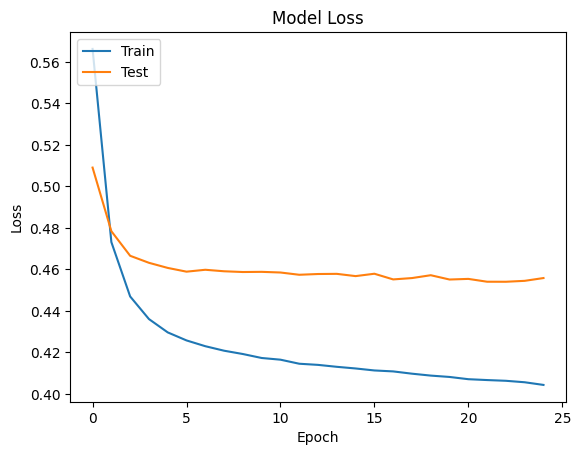

In [39]:
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss');
plt.ylabel('Loss');
plt.xlabel('Epoch');
plt.legend(['Train', 'Test'], loc='upper left');

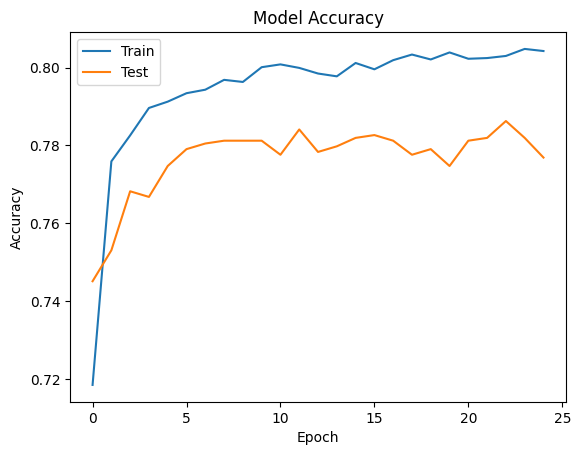

In [40]:
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy');
plt.ylabel('Accuracy');
plt.xlabel('Epoch');
plt.legend(['Train', 'Test'], loc='upper left');

### Now try running it with another optimizer

In [44]:
qt_relu_layers = n_features * 1.5
opt = 'Adam'
batch_size = 64
epochs = 25
model = get_model(layers=qt_relu_layers, optimizer=opt)
history = model.fit(X_train_std, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=True,
                    validation_data=(X_val_std, y_val))
score = model.evaluate(X_val_std, y_val, verbose=0)
print('-----------------------------------------------------')
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
print('Validation F1 score:', score[2])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 24)                408       
                                                                 
 dense_7 (Dense)             (None, 12)                300       
                                                                 
 dense_8 (Dense)             (None, 1)                 13        
                                                                 
Total params: 721 (2.82 KB)
Trainable params: 721 (2.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/25
87/87 [==============================] - 4s 14ms/step - loss: 0.6591 - accuracy: 0.6125 - f1_m: 0.5012 - val_loss: 0.5691 - val_accuracy: 0.7220 - val_f1_m: 0.6916
Epoch 2/25
87/87 [==============================] - 1s 8ms/step - loss: 0.5091 - accuracy: 0.7589 - f1_m: 0.7501 

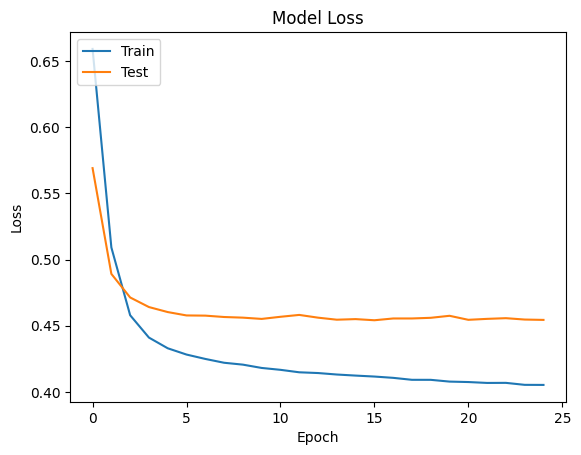

In [45]:
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss');
plt.ylabel('Loss');
plt.xlabel('Epoch');
plt.legend(['Train', 'Test'], loc='upper left');

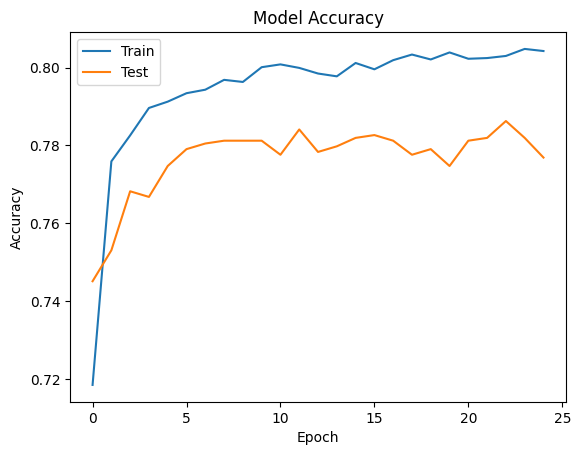

In [43]:
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy');
plt.ylabel('Accuracy');
plt.xlabel('Epoch');
plt.legend(['Train', 'Test'], loc='upper left');

In [46]:
## The model performed better with Adam as the optimizer
## I could run a grid search to detemine the best optimizer, but I decided to keep it simple

# Step 6: Evaluate the results in the Validation set

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [74]:
y_hat_val = model.predict(X_val_std)
y_hat_val = np.where(
    y_hat_val > .5,
    1,
    0
)

44/44 [==============================] - 0s 6ms/step


In [81]:
cm = confusion_matrix(y_val, y_hat_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Transported', 'Transported'])

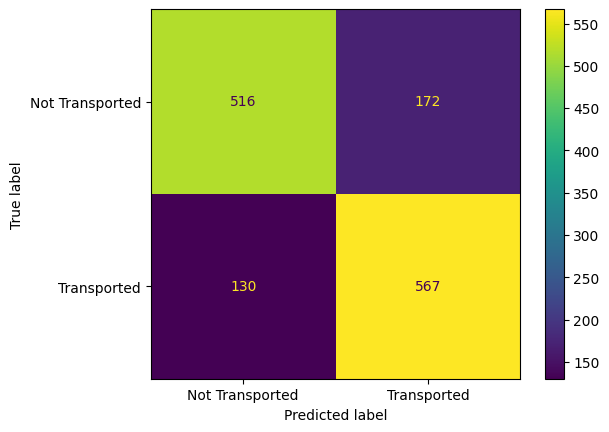

In [86]:
disp.plot()
%matplotlib inline

In [95]:
flat_y_hat_val = [item for sublist in y_hat_val for item in sublist]
flat_y_hat_val = np.array(flat_list)
flat_y_hat_val

array([1, 0, 1, ..., 0, 1, 0])

In [98]:
acc = (flat_y_hat_val == y_val).sum() / len(y_val)
prec = ((flat_y_hat_val == 1) & (y_val == 1)).sum() / (flat_y_hat_val == 1).sum()
rec = ((flat_y_hat_val == 1) & (y_val == 1)).sum() / (y_val == 1).sum()

print('Accuracy', acc)
print('Precision', prec)
print('Recall', rec)


Accuracy 0.7819494584837545
Precision 0.7672530446549392
Recall 0.8134863701578192


# Step 7: Applying the model to the Test dataset
I just did this to get the forecasts in the test dataset

In [47]:
df = pd.read_csv('Data/test.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [48]:
def last_name(name):
  name = str(name)
  return name.split(' ')[-1]

def first_name(name):
  name = str(name)
  return name.split(' ')[0]

In [49]:
df['Family'] = df['Name'].apply(lambda name: last_name(name))

In [50]:
# Trying to get an idea of how many people there are in each family
df_fam_size = df[['Family', 'Name']].groupby('Family').agg({'Name': 'count'}).reset_index().rename({'Name': 'FamilySize'}, axis='columns').sort_values(by='FamilySize', ascending=False)

# Adding the Family Size to the original dataframe
df_family = df[['Family', 'Name']].groupby('Family').size().reset_index(name='FamilySize')
df = df.merge(df_fam_size, on='Family', how='left')

In [51]:
df['Family'] = df['Family'].str.replace('nan', 'Unknown')

In [52]:
df['GroupOfTravellers'] = df['PassengerId'].str[:4]

In [53]:
df['GroupOfTravellers'].nunique()

3063

In [54]:
df_group = df[['GroupOfTravellers', 'PassengerId']].groupby('GroupOfTravellers').size().reset_index(name='GroupSize')
df = df.merge(df_group, on='GroupOfTravellers', how='left')

In [55]:
# There are far too many groups of travellers, therefore I won't use this information as is
# I could have created a custom boolean column for identifying groups where there are 2 or more families,
# But I decided to go with something simple

In [56]:
df.drop(['PassengerId', 'Name', 'GroupOfTravellers', 'Family', 'Cabin'], axis='columns', inplace=True)

In [57]:
df = pd.concat([df.drop(['HomePlanet', 'Destination'], axis='columns'),
                pd.get_dummies(df['HomePlanet'], prefix='HomePlanet'),
                pd.get_dummies(df['Destination'], prefix='Destination')], axis='columns')

In [58]:
df['CryoSleep'] = np.where(
    df['CryoSleep'].isna(),
    False,
    df['CryoSleep'].isna()
)
df['CryoSleep'] = df['CryoSleep'].astype('int')

df['VIP'] = np.where(
    df['VIP'].isna(),
    False,
    df['VIP'].isna()
)
df['VIP'] = df['VIP'].astype('int')


In [59]:
df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,FamilySize,GroupSize,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0,27.0,0,0.0,0.0,0.0,0.0,0.0,4,1,1,0,0,0,0,1
1,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,1,1,1,0,0,0,0,1
2,0,31.0,0,0.0,0.0,0.0,0.0,0.0,1,1,0,1,0,1,0,0
3,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,1,1,0,1,0,0,0,1
4,0,20.0,0,10.0,0.0,635.0,0.0,0.0,3,1,1,0,0,0,0,1


In [61]:
X_test = df

In [62]:
n_features = X_test.shape[1]

In [63]:
# Scaling the data
X_test_std = sc.transform(X_test)

In [64]:
y_hat = model.predict(X_test)

134/134 [==============================] - 1s 3ms/step


In [66]:
df['Transported'] = y_hat
df['Transported'] = np.where(
    df['Transported'] > 0.5,
    1,
    0
)

In [67]:
df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,FamilySize,GroupSize,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Transported
0,0,27.0,0,0.0,0.0,0.0,0.0,0.0,4,1,1,0,0,0,0,1,1
1,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,1,1,1,0,0,0,0,1,0
2,0,31.0,0,0.0,0.0,0.0,0.0,0.0,1,1,0,1,0,1,0,0,1
3,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,1,1,0,1,0,0,0,1,1
4,0,20.0,0,10.0,0.0,635.0,0.0,0.0,3,1,1,0,0,0,0,1,1
